# Experiments with Bayesian Linear Regression

This repository contains Python code for implementing Bayesian linear regression experiments with the tasks outlined below. The code not use special libraries or modules other than standard I/O, math, and plotting libraries.


### Task 1: Regularization

The goal of this task is to explore the role of regularization in linear regression and investigate the impact of regularization parameters on model performance. The code provided performs regularized linear regression for four datasets and plots the training set MSE and test set MSE as functions of the regularization parameter lambda. The results are compared to the MSE of the true functions given in the assignment.

### Task 2: Model Selection using Cross Validation

In this task, the code implements 10-fold cross-validation on the training set to select the optimal value of lambda. It then retrains the model on the entire training set with the selected lambda value and evaluates the performance on the test set.

### Task 3: Bayesian Model Selection

This task involves Bayesian linear regression with the utilization of the evidence function for parameter selection. The code initializes alpha and beta, then applies an iterative algorithm to select alpha and beta using the training set. It calculates the mean squared error (MSE) on the test set using the Maximum A Posteriori (MAP) for prediction. The scheme converges within a reasonable number of iterations.

### Prerequisites
Before running the code, make sure you have the following prerequisites installed:

• Python 3.x

• NumPy

• Matplotlib

You can install the required packages using pip:


###Data
There are 4 datasets and each dataset comes in 4 files with the training set in train-name.csv, the corresponding labels (regression values) in trainR-name.csv and similarly for test set. Here I have uploaded all of these datasets in the colab environment one by one. All 4 datasets corresponding to each main dataset have to be in the environment for the code to work.

#**Task 1 - Regularization**

In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
# Function to load data from CSV files
def load_data(train_file, label_file, test_file, test_label_file):
    train_data = np.loadtxt(train_file, delimiter=",")
    train_label = np.loadtxt(label_file, delimiter=",")
    test_data = np.loadtxt(test_file, delimiter=",")
    test_label = np.loadtxt(test_label_file, delimiter=",")

    return train_data, train_label, test_data, test_label

In [25]:
# Function to calculate regularized linear regression
def regularized_linear_regression(train_data, train_label, test_data, test_label, lambd_values):
    mse_train = []
    mse_test = []
    for lambd in lambd_values:
        phi = np.insert(train_data, 0, 1, axis=1)  # Add bias term
        phi_test = np.insert(test_data, 0, 1, axis=1)  # Add bias term
        identity = np.identity(phi.shape[1])
        w = np.linalg.inv(lambd * identity + np.dot(phi.T, phi)).dot(phi.T).dot(train_label)

        # Compute predictions
        pred_train = phi.dot(w)
        pred_test = phi_test.dot(w)

        # Calculate MSE
        mse_train.append(np.mean((pred_train - train_label) ** 2))
        mse_test.append(np.mean((pred_test - test_label) ** 2))

    return mse_train, mse_test

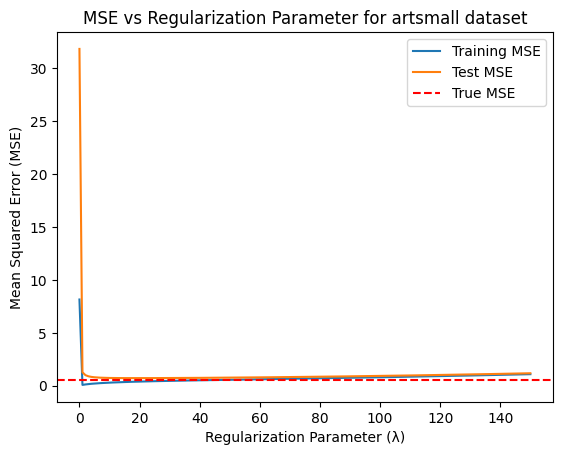

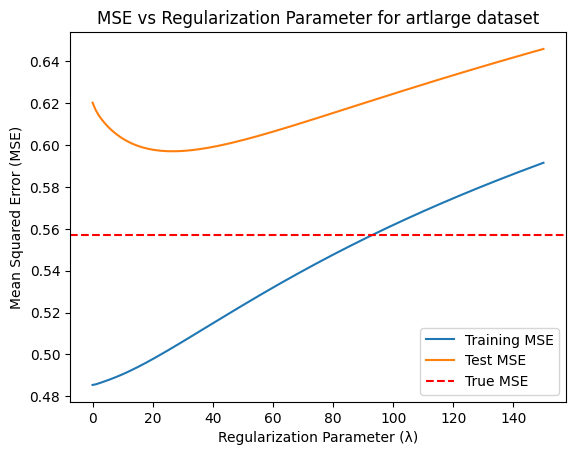

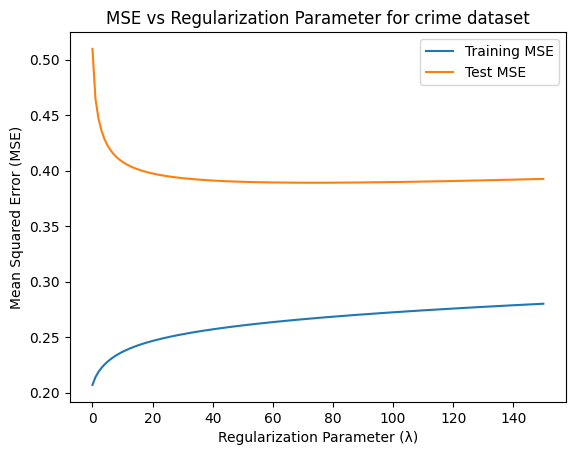

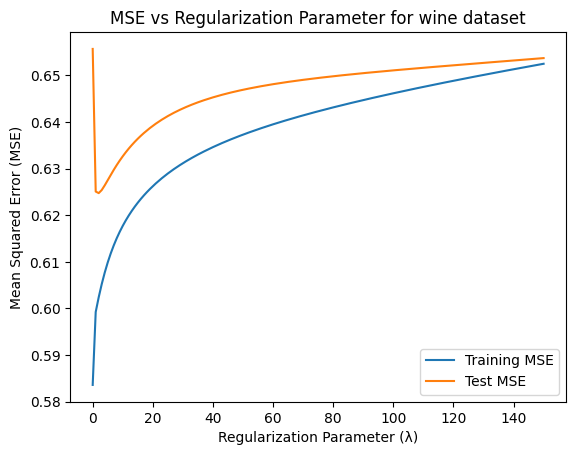

In [26]:
# Load and process data for each dataset
datasets = ['artsmall', 'artlarge', 'crime', 'wine']
lambd_values = range(151)  # Integer values from 0 to 150

for dataset in datasets:
    train_data, train_label, test_data, test_label = load_data(f"train-{dataset}.csv", f"trainR-{dataset}.csv",
                                                              f"test-{dataset}.csv", f"testR-{dataset}.csv")
    mse_train, mse_test = regularized_linear_regression(train_data, train_label, test_data, test_label, lambd_values)

    # Plotting
    plt.plot(lambd_values, mse_train, label='Training MSE')
    plt.plot(lambd_values, mse_test, label='Test MSE')
    if dataset == 'artsmall':
        true_mse = 0.533
    elif dataset == 'artlarge':
        true_mse = 0.557
    else:
        true_mse = None

    if true_mse:
        plt.axhline(y=true_mse, color='r', linestyle='--', label='True MSE')

    plt.xlabel('Regularization Parameter (λ)')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title(f'MSE vs Regularization Parameter for {dataset} dataset')
    plt.legend()
    plt.show()

#**Task 2 - Model Selection using Cross Validation**

In [27]:
import time

# Function for performing 10-fold cross-validation
def cross_validation(train_data, train_label, lambd_values):
    k = 10  # Number of folds
    fold_size = len(train_data) // k
    mse_cv = []

    for lambd in lambd_values:
        mse_sum = 0
        for i in range(k):
            #validation data for the current fold
            val_data = train_data[i * fold_size: (i + 1) * fold_size]
            val_label = train_label[i * fold_size: (i + 1) * fold_size]

            #training set for the current fold
            train_data_fold = np.concatenate([train_data[:i * fold_size], train_data[(i + 1) * fold_size:]])
            train_label_fold = np.concatenate([train_label[:i * fold_size], train_label[(i + 1) * fold_size:]])

            phi=train_data_fold
            identity = np.identity(phi.shape[1])
            #solution vector
            w = np.linalg.inv(lambd * identity + np.dot(phi.T, phi)).dot(phi.T).dot(train_label_fold)


            phi_val=val_data
            pred_val = phi_val.dot(w)
            mse_sum += np.mean((pred_val - val_label) ** 2)

        mse_cv.append(mse_sum / k)

    best_lambd_index = np.argmin(mse_cv)
    best_lambd = lambd_values[best_lambd_index]

    return best_lambd

In [28]:
# Perform 10-fold cross-validation for each dataset
for dataset in datasets:
    train_data, train_label, _, _ = load_data(f"train-{dataset}.csv", f"trainR-{dataset}.csv",
                                             f"test-{dataset}.csv", f"testR-{dataset}.csv")
    start_time = time.time()
    best_lambda = cross_validation(train_data, train_label, lambd_values)
    end_time = time.time()
    print(f"For {dataset} dataset:")
    print(f"Selected lambda value: {best_lambda}")
    print(f"Runtime: {end_time - start_time} seconds")
    print()

For artsmall dataset:
Selected lambda value: 18
Runtime: 1.2804248332977295 seconds

For artlarge dataset:
Selected lambda value: 23
Runtime: 3.1378607749938965 seconds

For crime dataset:
Selected lambda value: 150
Runtime: 2.2234947681427 seconds

For wine dataset:
Selected lambda value: 3
Runtime: 0.41896557807922363 seconds



#**Task 3 - Bayesian Model Selection**

In [29]:
# Function for Bayesian model selection
def bayesian_model_selection(train_data, train_label):
    #Initialize alpha and beta with random values in the range [1, 10]
    alpha = np.random.uniform(1, 10)
    beta = np.random.uniform(1, 10)

    #updating alpha and beta until convergence
    while True:
        phi = train_data
        identity = np.identity(phi.shape[1])

        #calculating gamma
        gamma = np.sum([np.linalg.norm(row) ** 2 / (alpha + np.linalg.norm(row) ** 2) for row in phi])

        mN = beta * np.linalg.inv(alpha * identity + beta * phi.T.dot(phi)).dot(phi.T).dot(train_label)

        #alpha and beta
        alpha_new = gamma / np.linalg.norm(mN) ** 2
        beta_new = 1 / (len(train_data) - gamma) * np.sum((train_label - phi.dot(mN)) ** 2)

        #checking convergence
        if abs(alpha - alpha_new) < 0.0001 and abs(beta - beta_new) < 0.0001:
            break

        alpha, beta = alpha_new, beta_new

    effective_lambda = alpha / beta
    #prediction for test set
    pred_test = test_data.dot(mN)
    #mean square error
    mse = np.mean((pred_test - test_label) ** 2)

    return alpha, beta, effective_lambda, mse

In [30]:
# Perform Bayesian model selection for each dataset
for dataset in datasets:
    #Load the training and test data for each dataset
    train_data, train_label, test_data, test_label = load_data(f"train-{dataset}.csv", f"trainR-{dataset}.csv",
                                                              f"test-{dataset}.csv", f"testR-{dataset}.csv")
    start_time = time.time()
    alpha, beta, effective_lambda, mse = bayesian_model_selection(train_data, train_label)
    end_time = time.time()
    print(f"For {dataset} dataset:")
    print(f"Alpha: {alpha}, Beta: {beta}, Effective Lambda: {effective_lambda}")
    print(f"MSE: {mse}, Runtime: {end_time - start_time} seconds")
    print()

For artsmall dataset:
Alpha: 9.628551373980121, Beta: 1.1913006906509251, Effective Lambda: 8.082385454438958
MSE: 0.749534409230876, Runtime: 0.12442445755004883 seconds

For artlarge dataset:
Alpha: 52.39198736066086, Beta: 0.8668459902352704, Effective Lambda: 60.43978740265173
MSE: 0.6060600696121685, Runtime: 0.9107644557952881 seconds

For crime dataset:
Alpha: 1844.439946372136, Beta: 0.4425875268431796, Effective Lambda: 4167.401552248602
MSE: 0.582108890461538, Runtime: 0.19109582901000977 seconds

For wine dataset:
Alpha: 1487.3631583272931, Beta: 8.518729907285156, Effective Lambda: 174.59916848112664
MSE: 0.6556128458411844, Runtime: 0.15520000457763672 seconds

